In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import pandas as pd
import keras.datasets.cifar10
import cv2
from PIL import Image
from sklearn.decomposition import PCA

### Load CIFAR10 automobile images 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
x_train.shape # 50,000 images of size 32x32

(50000, 32, 32, 3)

In [4]:
# get samples with index = 1 (automobile)
index = np.where(y_train.reshape(-1) == 1)
x_train_1 = x_train[index]
print(x_train_1.shape) # 5000 images of automobiles

(5000, 32, 32, 3)


In [6]:
n_samples = 2000 # should be less than 5000

data = x_train_1[0:n_samples,:,:,:] # save as many images as subjects
data = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in data]) # convert images to grayscale
print(data.shape)

(2000, 32, 32)


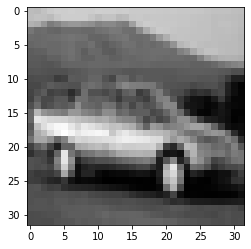

In [7]:
plt.imshow(data[0,:,:], cmap='gray')

### PCA

In [8]:
images = pd.DataFrame()

for i in range(n_samples):
    img = data[i]
    img = img.astype(np.uint8) # range from 0 to 255
    img = img / 255  # normalize values
    add = pd.Series(img.flatten(), name=i)
    images = images.append(add)

In [9]:
print(img[0:3,0:3]) # check the values in the last image
print(images.head())

[[0.19607843 0.18039216 0.16470588]
 [0.18431373 0.19607843 0.19215686]
 [0.14901961 0.23137255 0.27843137]]
       0         1         2         3         4         5         6     \
0  0.721569  0.713725  0.741176  0.772549  0.788235  0.784314  0.792157   
1  0.423529  0.388235  0.400000  0.498039  0.525490  0.584314  0.407843   
2  0.211765  0.215686  0.192157  0.266667  0.411765  0.282353  0.125490   
3  0.635294  0.658824  0.662745  0.666667  0.658824  0.650980  0.654902   
4  0.117647  0.125490  0.137255  0.105882  0.082353  0.113725  0.117647   

       7         8         9     ...      1014      1015      1016      1017  \
0  0.784314  0.784314  0.780392  ...  0.349020  0.337255  0.325490  0.313725   
1  0.188235  0.156863  0.168627  ...  0.098039  0.109804  0.117647  0.125490   
2  0.082353  0.074510  0.043137  ...  0.662745  0.666667  0.631373  0.615686   
3  0.643137  0.650980  0.690196  ...  0.360784  0.368627  0.329412  0.341176   
4  0.101961  0.086275  0.074510  ...  0.

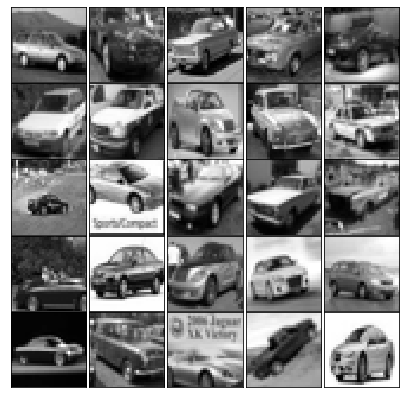

In [10]:
# plot original images
fig, axes = plt.subplots(5,5,figsize=(7,7),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(images.iloc[i].values.reshape(32,32), cmap='gray')

In [27]:
# fit PCA
images_pca = PCA(n_components = 0.8) # return the eigenvectors that have 80% of the variation
X = images_pca.fit_transform(images.iloc[:])  # Y_tilde

print(images_pca.components_.shape)   # first dim is the number of PCs
print(X.shape)

(30, 1024)
(2000, 30)


In [28]:
# save the covariate matrix
pd.DataFrame(X).to_csv('./data_for_R/High-dim_small-images/X.csv', index=False)

In [26]:
# variance of principal components
print('Explained Variation per Principal Component: \n {}'.format(images_pca.explained_variance_ratio_))

Explained Variation per Principal Component: 
 [0.29286895 0.10193114 0.07892545 0.03725579 0.03287519 0.0272969
 0.02680709 0.02237704 0.02149842 0.01711473 0.01471113 0.01222856
 0.01200318 0.01046035 0.00881007 0.00814451 0.00720231 0.00687187
 0.00681988 0.00642095 0.00623092 0.00546433 0.0051825  0.0050788
 0.00477734 0.00456726 0.00437509 0.00397575 0.0039467  0.0038728 ]


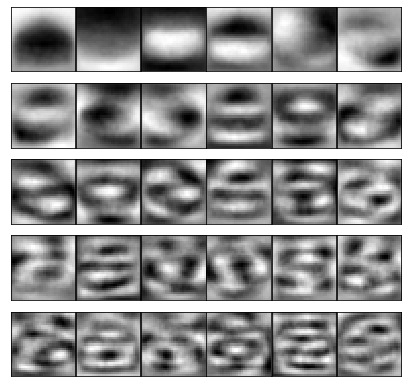

In [17]:
# plot principal components
fig, axes = plt.subplots(5,6,figsize=(7,7),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(images_pca.components_[i].reshape(32,32),cmap='gray')

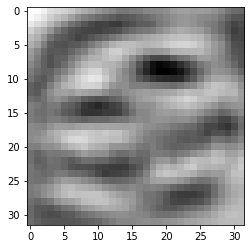

In [23]:
# plot the 30th principal component
plt.imshow(images_pca.components_[29].reshape(32,32),cmap='gray')

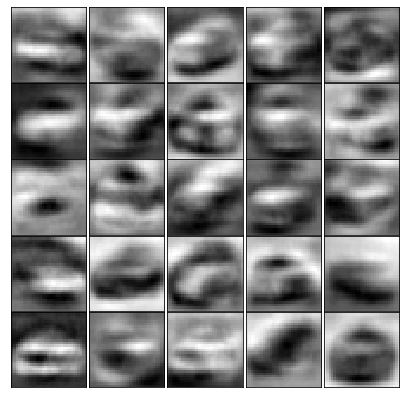

In [29]:
# map the (compressed) images back to the original space: X_tilde
projected = images_pca.inverse_transform(X)   # use eigenvectors to get the original images (transform data back to its original space)

fig, axes = plt.subplots(5,5,figsize=(7,7), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(32,32), cmap="gray")

### Setting

In [31]:
np.random.seed(12)
W = np.random.binomial(1, scipy.special.expit(np.random.normal(0, 1, size=n_samples)))

print('W.shape',W.shape)

pd.DataFrame(W).to_csv('./data_for_R/High-dim_small-images/W.csv', index=False)

W.shape (2000,)


In [32]:
np.random.seed(123)
e = np.random.normal(0, 1, size=n_samples) # gaussian noise 1, used in Y

print('e.shape',e.shape)

e.shape (2000,)


In [33]:
np.random.seed(1234)
h = np.random.normal(0, 1, size=n_samples) # gaussian noise 2, used in mu

print('h.shape',h.shape)

h.shape (2000,)


### no TE & no HTE

In [36]:
np.random.seed(12345)
mu = 2*h
Y = mu + e

print('mu.shape',mu.shape)
print('Y.shape',Y.shape)
print('cor(Y,W)',round(np.corrcoef(Y,W)[0,1], 3))
for col in range(X.shape[1]):
    print('cor(mu,X)','col',col,round(np.corrcoef(mu,X[:,col])[0,1], 3))
for col in range(X.shape[1]):
    print('cor(Y,X) ','col',col,round(np.corrcoef(Y,X[:,col])[0,1], 3))
    
pd.DataFrame(Y).to_csv('./data_for_R/High-dim_small-images/Y_noTE_noHTE.csv', index=False)

mu.shape (2000,)
Y.shape (2000,)
cor(Y,W) 0.01
cor(mu,X) col 0 0.047
cor(mu,X) col 1 0.035
cor(mu,X) col 2 0.021
cor(mu,X) col 3 -0.013
cor(mu,X) col 4 0.0
cor(mu,X) col 5 -0.033
cor(mu,X) col 6 0.007
cor(mu,X) col 7 -0.05
cor(mu,X) col 8 -0.006
cor(mu,X) col 9 -0.003
cor(mu,X) col 10 -0.009
cor(mu,X) col 11 -0.011
cor(mu,X) col 12 -0.008
cor(mu,X) col 13 -0.006
cor(mu,X) col 14 -0.002
cor(mu,X) col 15 -0.021
cor(mu,X) col 16 -0.002
cor(mu,X) col 17 -0.003
cor(mu,X) col 18 -0.013
cor(mu,X) col 19 0.032
cor(mu,X) col 20 -0.042
cor(mu,X) col 21 -0.004
cor(mu,X) col 22 0.013
cor(mu,X) col 23 -0.022
cor(mu,X) col 24 -0.02
cor(mu,X) col 25 -0.011
cor(mu,X) col 26 0.006
cor(mu,X) col 27 -0.03
cor(mu,X) col 28 0.028
cor(mu,X) col 29 0.004
cor(Y,X)  col 0 0.049
cor(Y,X)  col 1 0.029
cor(Y,X)  col 2 0.019
cor(Y,X)  col 3 -0.032
cor(Y,X)  col 4 0.001
cor(Y,X)  col 5 -0.028
cor(Y,X)  col 6 0.01
cor(Y,X)  col 7 -0.049
cor(Y,X)  col 8 -0.012
cor(Y,X)  col 9 -0.008
cor(Y,X)  col 10 -0.011
cor(Y,X)  

### TE & no HTE

In [38]:
np.random.seed(12345)
mu = np.random.normal(0, 1, size=n_samples)
mu = mu + W + h   # rnorm_pre()와 같은 함수가 없어서 우선 이렇게 정의
mu_W = np.matmul(mu.reshape(n_samples,-1), W.reshape(-1, n_samples))
Y = mu_W.mean(axis=1) + e

print('cor(mu,,W)',round(np.corrcoef(mu,W)[0,1], 3))
print('cor(Y,W)',round(np.corrcoef(Y,W)[0,1], 3))
for col in range(X.shape[1]):
    print('cor(mu,X)','col',col,round(np.corrcoef(mu,X[:,col])[0,1], 3))
for col in range(X.shape[1]):
    print('cor(Y,X) ','col',col,round(np.corrcoef(Y,X[:,col])[0,1], 3))
    
pd.DataFrame(Y).to_csv('./data_for_R/High-dim_small-images/Y_TE_noHTE.csv', index=False)

cor(mu,,W) 0.35
cor(Y,W) 0.214
cor(mu,X) col 0 0.05
cor(mu,X) col 1 0.033
cor(mu,X) col 2 -0.004
cor(mu,X) col 3 0.004
cor(mu,X) col 4 0.024
cor(mu,X) col 5 -0.038
cor(mu,X) col 6 -0.013
cor(mu,X) col 7 -0.042
cor(mu,X) col 8 -0.036
cor(mu,X) col 9 0.005
cor(mu,X) col 10 -0.009
cor(mu,X) col 11 -0.0
cor(mu,X) col 12 -0.002
cor(mu,X) col 13 0.006
cor(mu,X) col 14 -0.018
cor(mu,X) col 15 -0.012
cor(mu,X) col 16 0.01
cor(mu,X) col 17 -0.008
cor(mu,X) col 18 -0.045
cor(mu,X) col 19 0.038
cor(mu,X) col 20 -0.06
cor(mu,X) col 21 0.024
cor(mu,X) col 22 0.003
cor(mu,X) col 23 -0.02
cor(mu,X) col 24 0.001
cor(mu,X) col 25 -0.01
cor(mu,X) col 26 0.013
cor(mu,X) col 27 0.004
cor(mu,X) col 28 0.008
cor(mu,X) col 29 -0.016
cor(Y,X)  col 0 0.043
cor(Y,X)  col 1 0.017
cor(Y,X)  col 2 -0.001
cor(Y,X)  col 3 -0.034
cor(Y,X)  col 4 0.016
cor(Y,X)  col 5 -0.021
cor(Y,X)  col 6 -0.0
cor(Y,X)  col 7 -0.035
cor(Y,X)  col 8 -0.034
cor(Y,X)  col 9 -0.007
cor(Y,X)  col 10 -0.009
cor(Y,X)  col 11 -0.002
cor(Y,X

### TE & HTE (only protective factors)

In [40]:
np.random.seed(12345)
mu = np.random.normal(0, 1, size=n_samples) + W + X[:,0:2].mean(axis=1) + h
Y = mu*W + e

print('cor(mu,W)',round(np.corrcoef(mu,W)[0,1], 3))
print('cor(Y,W)',round(np.corrcoef(Y,W)[0,1], 3))
for col in range(X.shape[1]):
    print('cor(mu,X)','col',col,round(np.corrcoef(mu,X[:,col])[0,1], 3))
for col in range(X.shape[1]):
    print('cor(Y,X) ','col',col,round(np.corrcoef(Y,X[:,col])[0,1], 3))
    
pd.DataFrame(Y).to_csv('./data_for_R/High-dim_small-images/Y_TE_protHTE.csv', index=False)

cor(mu,W) 0.176
cor(Y,W) 0.226
cor(mu,X) col 0 0.75
cor(mu,X) col 1 0.444
cor(mu,X) col 2 -0.002
cor(mu,X) col 3 0.002
cor(mu,X) col 4 0.012
cor(mu,X) col 5 -0.019
cor(mu,X) col 6 -0.007
cor(mu,X) col 7 -0.021
cor(mu,X) col 8 -0.018
cor(mu,X) col 9 0.003
cor(mu,X) col 10 -0.004
cor(mu,X) col 11 -0.0
cor(mu,X) col 12 -0.001
cor(mu,X) col 13 0.003
cor(mu,X) col 14 -0.009
cor(mu,X) col 15 -0.006
cor(mu,X) col 16 0.005
cor(mu,X) col 17 -0.004
cor(mu,X) col 18 -0.022
cor(mu,X) col 19 0.019
cor(mu,X) col 20 -0.03
cor(mu,X) col 21 0.012
cor(mu,X) col 22 0.001
cor(mu,X) col 23 -0.01
cor(mu,X) col 24 0.0
cor(mu,X) col 25 -0.005
cor(mu,X) col 26 0.007
cor(mu,X) col 27 0.002
cor(mu,X) col 28 0.004
cor(mu,X) col 29 -0.008
cor(Y,X)  col 0 0.492
cor(Y,X)  col 1 0.268
cor(Y,X)  col 2 0.005
cor(Y,X)  col 3 -0.042
cor(Y,X)  col 4 0.031
cor(Y,X)  col 5 0.003
cor(Y,X)  col 6 -0.019
cor(Y,X)  col 7 -0.025
cor(Y,X)  col 8 -0.021
cor(Y,X)  col 9 0.008
cor(Y,X)  col 10 -0.009
cor(Y,X)  col 11 0.014
cor(Y,X) 

### TE & HTE (only risk factors)

In [41]:
np.random.seed(12345)
mu = np.random.normal(0, 1, size=n_samples) + W - X[:,2:4].mean(axis=1) + h
Y = mu*W + e

print('cor(mu,W)',round(np.corrcoef(mu,W)[0,1], 3))
print('cor(Y,W)',round(np.corrcoef(Y,W)[0,1], 3))
for col in range(X.shape[1]):
    print('cor(mu,X)','col',col,round(np.corrcoef(mu,X[:,col])[0,1], 3))
for col in range(X.shape[1]):
    print('cor(Y,X) ','col',col,round(np.corrcoef(Y,X[:,col])[0,1], 3))
    
pd.DataFrame(Y).to_csv('./data_for_R/High-dim_small-images/Y_TE_riskHTE.csv', index=False)

cor(mu,W) 0.26
cor(Y,W) 0.301
cor(mu,X) col 0 0.036
cor(mu,X) col 1 0.024
cor(mu,X) col 2 -0.564
cor(mu,X) col 3 -0.383
cor(mu,X) col 4 0.017
cor(mu,X) col 5 -0.028
cor(mu,X) col 6 -0.01
cor(mu,X) col 7 -0.031
cor(mu,X) col 8 -0.026
cor(mu,X) col 9 0.004
cor(mu,X) col 10 -0.006
cor(mu,X) col 11 -0.0
cor(mu,X) col 12 -0.001
cor(mu,X) col 13 0.004
cor(mu,X) col 14 -0.013
cor(mu,X) col 15 -0.009
cor(mu,X) col 16 0.007
cor(mu,X) col 17 -0.005
cor(mu,X) col 18 -0.033
cor(mu,X) col 19 0.028
cor(mu,X) col 20 -0.044
cor(mu,X) col 21 0.017
cor(mu,X) col 22 0.002
cor(mu,X) col 23 -0.015
cor(mu,X) col 24 0.0
cor(mu,X) col 25 -0.007
cor(mu,X) col 26 0.01
cor(mu,X) col 27 0.003
cor(mu,X) col 28 0.006
cor(mu,X) col 29 -0.012
cor(Y,X)  col 0 0.055
cor(Y,X)  col 1 0.02
cor(Y,X)  col 2 -0.32
cor(Y,X)  col 3 -0.251
cor(Y,X)  col 4 0.022
cor(Y,X)  col 5 -0.029
cor(Y,X)  col 6 -0.015
cor(Y,X)  col 7 -0.003
cor(Y,X)  col 8 -0.008
cor(Y,X)  col 9 0.011
cor(Y,X)  col 10 -0.006
cor(Y,X)  col 11 -0.003
cor(Y,X

### TE & HTE (both protective and risk factors)

In [42]:
np.random.seed(12345)
mu = np.random.normal(0, 1, size=n_samples) + W + X[:,0:2].mean(axis=1) - X[:,2:4].mean(axis=1) + h
Y = mu*W + e

print('cor(mu,W)',round(np.corrcoef(mu,W)[0,1], 3))
print('cor(Y,W)',round(np.corrcoef(Y,W)[0,1], 3))
for col in range(X.shape[1]):
    print('cor(mu,X)','col',col,round(np.corrcoef(mu,X[:,col])[0,1], 3))
for col in range(X.shape[1]):
    print('cor(Y,X) ','col',col,round(np.corrcoef(Y,X[:,col])[0,1], 3))
    
pd.DataFrame(Y).to_csv('./data_for_R/High-dim_small-images/Y_TE_bothHTE.csv', index=False)

cor(mu,W) 0.163
cor(Y,W) 0.209
cor(mu,X) col 0 0.682
cor(mu,X) col 1 0.404
cor(mu,X) col 2 -0.344
cor(mu,X) col 3 -0.233
cor(mu,X) col 4 0.011
cor(mu,X) col 5 -0.017
cor(mu,X) col 6 -0.006
cor(mu,X) col 7 -0.019
cor(mu,X) col 8 -0.016
cor(mu,X) col 9 0.002
cor(mu,X) col 10 -0.004
cor(mu,X) col 11 -0.0
cor(mu,X) col 12 -0.001
cor(mu,X) col 13 0.003
cor(mu,X) col 14 -0.008
cor(mu,X) col 15 -0.006
cor(mu,X) col 16 0.004
cor(mu,X) col 17 -0.003
cor(mu,X) col 18 -0.02
cor(mu,X) col 19 0.017
cor(mu,X) col 20 -0.027
cor(mu,X) col 21 0.011
cor(mu,X) col 22 0.001
cor(mu,X) col 23 -0.009
cor(mu,X) col 24 0.0
cor(mu,X) col 25 -0.005
cor(mu,X) col 26 0.006
cor(mu,X) col 27 0.002
cor(mu,X) col 28 0.003
cor(mu,X) col 29 -0.007
cor(Y,X)  col 0 0.452
cor(Y,X)  col 1 0.252
cor(Y,X)  col 2 -0.214
cor(Y,X)  col 3 -0.186
cor(Y,X)  col 4 0.032
cor(Y,X)  col 5 -0.004
cor(Y,X)  col 6 -0.019
cor(Y,X)  col 7 -0.017
cor(Y,X)  col 8 -0.007
cor(Y,X)  col 9 0.009
cor(Y,X)  col 10 -0.007
cor(Y,X)  col 11 0.018
cor(

### Interpretation

In [ ]:
# marking the important PC's on the PC plo...?